In [4]:
#@markdown We implemented some functions to visualize the object detection results. <br/> Run the following cell to activate the functions.
import cv2
import numpy as np

MARGIN = 10  # pixels
ROW_SIZE = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
TEXT_COLOR = (255, 0, 0)  # red


def visualize(
    image,
    detection_result
) -> np.ndarray:
  """Draws bounding boxes on the input image and return it.
  Args:
    image: The input RGB image.
    detection_result: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  for detection in detection_result.detections:
    # Draw bounding_box
    bbox = detection.bounding_box
    start_point = bbox.origin_x, bbox.origin_y
    end_point = bbox.origin_x + bbox.width, bbox.origin_y + bbox.height
    cv2.rectangle(image, start_point, end_point, TEXT_COLOR, 3)

    # Draw label and score
    category = detection.categories[0]
    category_name = category.category_name
    probability = round(category.score, 2)
    result_text = category_name + ' (' + str(probability) + ')'
    text_location = (MARGIN + bbox.origin_x,
                     MARGIN + ROW_SIZE + bbox.origin_y)
    cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)

  return image

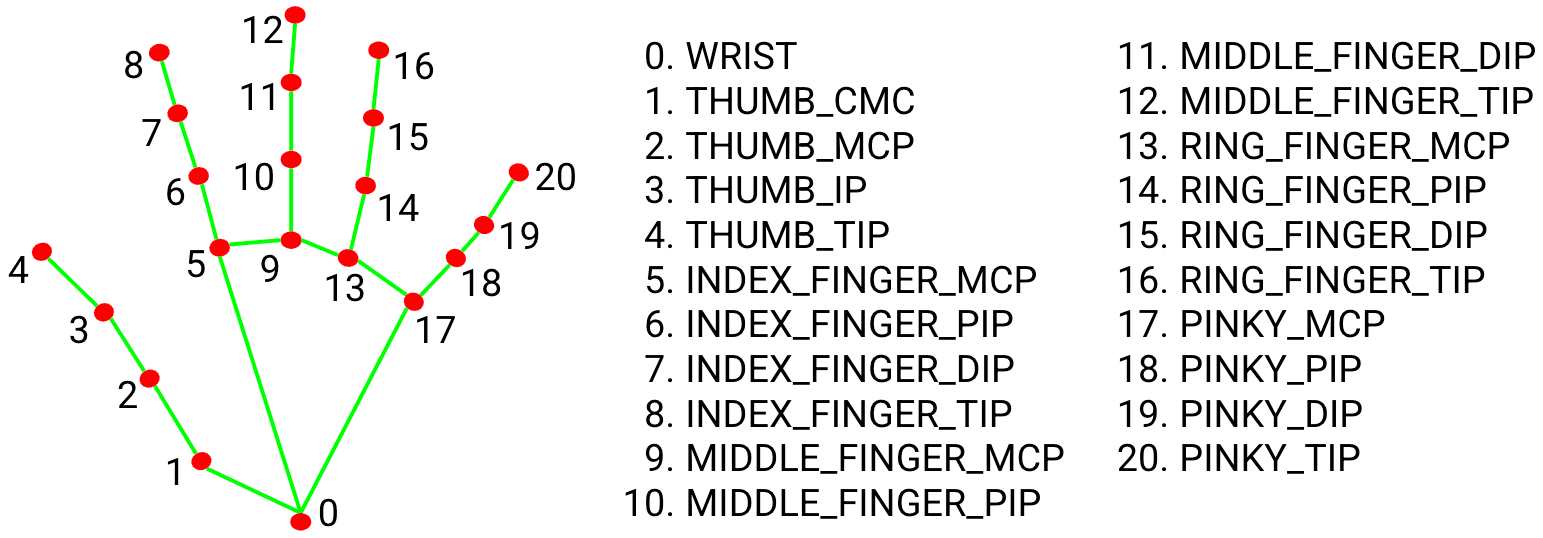

In [ ]:
import cv2
import mediapipe as mp
import math
import numpy as np
import pyautogui  # Used for minimizing the windows

# Important variables
cap = cv2.VideoCapture(0)  # Initialize video capture
mp_hands = mp.solutions.hands  # Mediapipe hands module
mp_drawing = mp.solutions.drawing_utils  # Drawing utilities for landmarks

# Frame dimensions
ret, frame = cap.read()
height, width, _ = frame.shape

# Canvas for drawing
canvas = np.zeros((height, width, 3), dtype=np.uint8)

# Lists to store collections of points for green and blue dots
current_points = []  # Stores the points when the fingers are close
all_blue_points = []  # Stores the blue dots based on middle and index finger distance
displayed_angle = None  # Store the angle for display

# Function to calculate the Euclidean distance between two points in 2D (screen space)
def calculate_screen_distance(point1, point2, width, height):
    x1, y1 = int(point1.x * width), int(point1.y * height)
    x2, y2 = int(point2.x * width), int(point2.y * height)
    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2), (x1, y1), (x2, y2)

# Function to calculate the angle between two points (first and last)
def calculate_angle(p1, p2):
    delta_x = p2[0] - p1[0]
    delta_y = p2[1] - p1[1]
    angle = math.degrees(math.atan2(delta_y, delta_x))
    return angle

with mp_hands.Hands(min_detection_confidence=0.8, min_tracking_confidence=0.5) as hands: 
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Flip the frame horizontally for a mirror-like effect
        frame = cv2.flip(frame, 1)

        # BGR to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Set flag to make the image non-writeable for better performance
        image.flags.writeable = False
        
        # Detections
        results = hands.process(image)
        
        # Set flag to true to make the image writeable again
        image.flags.writeable = True
        
        # RGB to BGR for displaying
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Rendering hand landmarks
        fingers_close = False  # A flag to track if the fingers are close in the current frame
        if results.multi_hand_landmarks:
            for num, hand in enumerate(results.multi_hand_landmarks):
                # Draw the hand landmarks on the frame
                mp_drawing.draw_landmarks(image, hand, mp_hands.HAND_CONNECTIONS, 
                                        mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
                                        mp_drawing.DrawingSpec(color=(250, 44, 250), thickness=2, circle_radius=2),
                                         )
                # Get the landmarks for thumb tip (4), middle finger tip (6), and index finger tip (8)
                thumb_tip = hand.landmark[4]
                middle_finger_tip = hand.landmark[6]
                index_finger_tip = hand.landmark[8]

                # Calculate the distance between the thumb tip and index finger tip in screen coordinates
                distance_thumb_index, thumb_pos, index_pos = calculate_screen_distance(thumb_tip, index_finger_tip, width, height)

                # Define a threshold for "closeness" in screen space (e.g., pixels)
                if distance_thumb_index < 40:  # Adjust threshold based on required "closeness"
                    # Calculate the midpoint of thumb and index finger tips
                    mid_point = (int((thumb_pos[0] + index_pos[0]) / 2), int((thumb_pos[1] + index_pos[1]) / 2))
                    current_points.append(mid_point)  # Add the point to the current collection
                    fingers_close = True  # Mark that the fingers are close

                # Calculate the distance between middle finger tip and index finger tip
                distance_middle_index, _, _ = calculate_screen_distance(middle_finger_tip, index_finger_tip, width, height)

                # If distance is less than 5 pixels, create blue dot
                if distance_middle_index < 5:
                    new_blue_dot = (int(index_pos[0]), int(index_pos[1]))
                    all_blue_points.append(new_blue_dot)  # Store the new blue dot

                # Draw a blue line between the middle finger tip and index finger tip
                middle_pos = calculate_screen_distance(middle_finger_tip, middle_finger_tip, width, height)[1]
                index_pos = calculate_screen_distance(index_finger_tip, index_finger_tip, width, height)[1]
                cv2.line(image, middle_pos, index_pos, color=(255, 0, 0), thickness=2)

                # Calculate length of the line and angle
                length, _, _ = calculate_screen_distance(middle_finger_tip, index_finger_tip, width, height)
                angle = calculate_angle(middle_pos, index_pos)

                # Display length and angle on the frame
                cv2.putText(image, f"Length: {length:.2f}px", (10, 100),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
                cv2.putText(image, f"Angle: {angle:.2f}°", (10, 150),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

        # If fingers were close in this frame but are now far apart
        if not fingers_close and current_points:
            if len(current_points) >= 2:
                # Calculate and display angle between first and last points of the collection
                first_point = current_points[0]
                last_point = current_points[-1]
                angle = calculate_angle(first_point, last_point)
                print(f"Angle between first and last points: {angle:.2f} degrees")
                displayed_angle = angle  # Store the angle for display

                # Check if both length is greater than 50 pixels and angle is between 125 and 155 degrees
                if length > 50 and 125 <= angle <= 155:
                    print("Minimizing all windows...")
                    pyautogui.hotkey('win', 'd')  # Simulate the 'Win + D' command to minimize all windows

            # Clear all points after the collection is completed
            current_points = []  # Reset the current points for the next segment
            canvas = np.zeros((height, width, 3), dtype=np.uint8)  # Clear canvas after points are too far apart

        # Draw the current segment (where the fingers are still close)
        for i in range(1, len(current_points)):
            cv2.line(canvas, current_points[i - 1], current_points[i], color=(0, 255, 0), thickness=2)

        # Draw the blue dots and connect them with lines
        if len(all_blue_points) > 1:
            for i in range(1, len(all_blue_points)):
                # Draw line between consecutive blue points
                cv2.line(image, all_blue_points[i - 1], all_blue_points[i], color=(255, 0, 0), thickness=2)

        # Check lengths of blue points and remove them if the distance exceeds 50 pixels
        if len(all_blue_points) > 1:
            new_blue_points = [all_blue_points[0]]  # Keep the first point
            for i in range(1, len(all_blue_points)):
                distance_between = calculate_screen_distance(all_blue_points[i - 1], all_blue_points[i], width, height)[0]
                if distance_between <= 50:
                    new_blue_points.append(all_blue_points[i])  # Keep the point if within 50 pixels
            all_blue_points = new_blue_points  # Update the list with filtered points

        # Display the interpreted angle on the frame
        if displayed_angle is not None:
            cv2.putText(image, f"Angle: {displayed_angle:.2f} degrees", (10, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

        # Overlay the canvas (drawing) on top of the frame
        combined_image = cv2.addWeighted(image, 0.8, canvas, 0.7, 0)

        # Display the result
        cv2.imshow('Hand Tracking with Drawing', combined_image)

        # Handle keypress events
        key = cv2.waitKey(10) & 0xFF
        if key == ord('q'):  # Quit the program
            break
        elif key == ord('e'):  # Clear the drawing (erase)
            current_points.clear()  # Clear the current points
            canvas = np.zeros((height, width, 3), dtype=np.uint8)  # Clear the canvas

cap.release()
cv2.destroyAllWindows()


In [8]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import math
import csv
import os

# Initialize video capture and Mediapipe
cap = cv2.VideoCapture(0)
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# CSV file to store gestures
csv_file = 'gestures.csv'

# Create the CSV file if it doesn't exist and add the header
if not os.path.exists(csv_file):
    with open(csv_file, mode='w', newline='') as f:
        writer = csv.writer(f)
        header = ['Gesture']
        for i in range(21):
            header += [f'Node_{i}_X'] + [f'Node_{i}_Y']
        writer.writerow(header)

# Function to calculate the angle of a line between two points
def calculate_angle(p1, p2):
    delta_x = p2[0] - p1[0]
    delta_y = p2[1] - p1[1]
    return math.atan2(delta_y, delta_x)

# Function to rotate points around the origin by a given angle
def rotate_point(point, angle_rad):
    x, y = point
    cos_theta = math.cos(angle_rad)
    sin_theta = math.sin(angle_rad)
    x_rotated = x * cos_theta - y * sin_theta
    y_rotated = x * sin_theta + y * cos_theta
    return (x_rotated, y_rotated)

# Save gesture data to the CSV file
def save_gesture_to_csv(gesture_name, positions):
    with open(csv_file, mode='a', newline='') as f:
        writer = csv.writer(f)
        row = [gesture_name] + [coord for pos in positions for coord in pos]
        writer.writerow(row)

with mp_hands.Hands(min_detection_confidence=0.8, min_tracking_confidence=0.5) as hands:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Flip the frame horizontally for a mirror-like effect
        frame = cv2.flip(frame, 1)

        # Convert BGR to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Process hand landmarks
        results = hands.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                # Get the position of landmark 0 (wrist) and landmark 9
                wrist = hand_landmarks.landmark[0]
                node_9 = hand_landmarks.landmark[9]

                # Get screen coordinates of wrist (node 0) and node 9
                wrist_pos = (wrist.x, wrist.y)
                node_9_pos = (node_9.x, node_9.y)

                # Calculate the angle to rotate the hand so node 9 is directly above node 0
                angle = calculate_angle(wrist_pos, node_9_pos)
                rotate_angle = math.pi / 2 + angle  # Rotate to make it straight up

                # Collect rotated positions of all landmarks relative to node 0
                rotated_positions = []
                for landmark in hand_landmarks.landmark:
                    # Relative position to landmark 0
                    relative_x = landmark.x - wrist.x
                    relative_y = landmark.y - wrist.y
                    # Rotate the point
                    rotated_x, rotated_y = rotate_point((relative_x, relative_y), rotate_angle)
                    rotated_positions.append((rotated_x, rotated_y))

                # Draw circles at the landmarks (nodes), but do not connect them with lines
                for idx, landmark in enumerate(hand_landmarks.landmark):
                    cx, cy = int(landmark.x * frame.shape[1]), int(landmark.y * frame.shape[0])
                    cv2.circle(image, (cx, cy), 5, (0, 255, 0), cv2.FILLED)

                # Handle keypress events
                key = cv2.waitKey(10) & 0xFF
                if key == ord('y'):  # Press 'y' to print relative positions and plot graph
                    # Print the rotated positions
                    print(f"Rotated positions of hand landmarks (relative to node 0 and rotated):")
                    for idx, pos in enumerate(rotated_positions):
                        print(f"Node {idx}: x={pos[0]:.4f}, y={pos[1]:.4f}")

                    # Plot the rotated positions on a graph
                    x_vals = [pos[0] for pos in rotated_positions]
                    y_vals = [pos[1] for pos in rotated_positions]

                    plt.figure()
                    plt.scatter(x_vals, y_vals, c='blue')
                    for i, (x, y) in enumerate(zip(x_vals, y_vals)):
                        plt.text(x, y, f"{i}", fontsize=12, color='red')  # Label the nodes
                    plt.title("Hand Landmarks (Rotated)")
                    plt.xlabel("X Position")
                    plt.ylabel("Y Position")
                    plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
                    plt.show()

                elif key == ord('j'):  # Press 'j' to save the gesture
                    # Prompt for gesture name
                    gesture_name = input("Enter the gesture name: ")
                    print(f"Saving gesture: {gesture_name}")
                    save_gesture_to_csv(gesture_name, rotated_positions)

        # Display the result
        cv2.imshow('Hand Tracking', image)

        # Quit the program if 'q' is pressed
        key = cv2.waitKey(10) & 0xFF
        if key == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()



Saving gesture: Fist


In [9]:
import cv2
import mediapipe as mp
import numpy as np
import math
import csv
import os
import matplotlib.pyplot as plt

# Initialize video capture and Mediapipe
cap = cv2.VideoCapture(0)
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# CSV file that stores gestures
csv_file = 'gestures.csv'

# Load gestures from CSV
gestures = []
if os.path.exists(csv_file):
    with open(csv_file, mode='r') as f:
        reader = csv.reader(f)
        header = next(reader)  # Skip header row
        for row in reader:
            gesture_name = row[0]
            coords = list(map(float, row[1:]))  # Convert strings to floats
            gesture_data = {'name': gesture_name, 'positions': [(coords[i], coords[i+1]) for i in range(0, 42, 2)]}
            gestures.append(gesture_data)

def calculate_distance(landmarks1, landmarks2):
    # Get node 0 and node 9 positions for both landmarks
    node0_1 = landmarks1[0]
    node9_1 = landmarks1[9]
    node0_2 = landmarks2[0]
    node9_2 = landmarks2[9]
    
    # Calculate distance between node 0 and node 9 for both landmark sets
    dist1 = math.sqrt((node0_1[0] - node9_1[0]) ** 2 + (node0_1[1] - node9_1[1]) ** 2)
    dist2 = math.sqrt((node0_2[0] - node9_2[0]) ** 2 + (node0_2[1] - node9_2[1]) ** 2)

    # Calculate scale factor to make landmarks2 match landmarks1 in scale
    scale_factor = dist1 / dist2 if dist2 != 0 else 1

    # Print the scale factor for debugging
    print(f"Scaling landmarks2 by a factor of {scale_factor:.4f} to match landmarks1.")

    # Scale landmarks2 by the scale factor
    scaled_landmarks2 = [(x * scale_factor, y * scale_factor) for x, y in landmarks2]

    # Plot the original landmarks1 and scaled landmarks2 on a 2D graph
    #fig, ax = plt.subplots()
    
    # Extract x and y coordinates for both sets
    x1, y1 = zip(*landmarks1)
    x2, y2 = zip(*scaled_landmarks2)
    
    # Plot landmarks1
    #ax.scatter(x1, y1, color='blue', label='Landmarks1')
    
    # Plot scaled landmarks2
    #ax.scatter(x2, y2, color='red', label='Scaled Landmarks2')
    
    
    # Set labels and title
    #ax.set_xlabel('X-axis')
    #ax.set_ylabel('Y-axis (scaled)')
    #ax.set_title('Landmarks Comparison')
    #ax.legend()
    
    # Show the plot
    plt.show()

    # Calculate the Euclidean distance between each corresponding node pair
    total_distance = 0
    for i in range(len(landmarks1)):
        x1, y1 = landmarks1[i]
        x2, y2 = scaled_landmarks2[i]  # Use scaled landmarks2
        
        # Correct the y-coordinate for the second set of landmarks
        y2 = y2
        
        # Calculate the Euclidean distance for this pair of nodes
        node_distance = math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
        
        # Add this node distance to the total distance
        total_distance += node_distance

    return total_distance



# Function to calculate the angle of a line between two points
def calculate_angle(p1, p2):
    delta_x = p2[0] - p1[0]
    delta_y = p2[1] - p1[1]
    return math.atan2(delta_y, delta_x)

# Function to rotate points around the origin by a given angle
def rotate_point(point, angle_rad):
    x, y = point
    cos_theta = math.cos(angle_rad)
    sin_theta = math.sin(angle_rad)
    x_rotated = x * cos_theta - y * sin_theta
    y_rotated = x * sin_theta + y * cos_theta
    return (x_rotated, y_rotated)

# Process the hand landmarks and compare with gestures
with mp_hands.Hands(min_detection_confidence=0.8, min_tracking_confidence=0.5) as hands:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Flip the frame horizontally for a mirror-like effect
        frame = cv2.flip(frame, 1)

        # Convert BGR to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Process hand landmarks
        results = hands.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                # Draw hand landmarks on the image
                mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

                # Get the position of landmark 0 (wrist) and landmark 9 (middle finger tip)
                wrist = hand_landmarks.landmark[0]
                node_9 = hand_landmarks.landmark[9]

                # Get screen coordinates of wrist (node 0) and node 9
                wrist_pos = (wrist.x, wrist.y)
                node_9_pos = (node_9.x, node_9.y)

                # Calculate the angle to rotate the hand so node 9 is directly above node 0
                angle = calculate_angle(wrist_pos, node_9_pos)
                rotate_angle = math.pi / 2 + angle  # Rotate to make it straight up

                # Collect rotated positions of all landmarks relative to node 0
                rotated_positions = []
                for landmark in hand_landmarks.landmark:
                    # Relative position to landmark 0
                    relative_x = landmark.x - wrist.x
                    relative_y = landmark.y - wrist.y
                    # Rotate the point
                    rotated_x, rotated_y = rotate_point((relative_x, relative_y), rotate_angle)
                    rotated_positions.append((relative_x, relative_y))

                # Draw line between node 0 and node 9
                wrist_screen = (int(wrist.x * frame.shape[1]), int(wrist.y * frame.shape[0]))
                node_9_screen = (int(node_9.x * frame.shape[1]), int(node_9.y * frame.shape[0]))
                cv2.line(image, wrist_screen, node_9_screen, (0, 255, 0), 2)

                # Find the closest gesture based on the Euclidean distance
                min_distance = float('inf')
                closest_gesture = None
                closest_gesture_positions = None

                for gesture in gestures:
                    distance = calculate_distance(rotated_positions, gesture['positions'])
                    if distance < min_distance:
                        min_distance = distance
                        closest_gesture = gesture['name']
                        closest_gesture_positions = gesture['positions']

                # Display the name of the closest gesture
                if closest_gesture:
                    cv2.putText(image, f"Gesture: {closest_gesture}", (10, 50),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)



        # Display the result with hand landmarks
        cv2.imshow('Hand Tracking - Gesture Recognition', image)

        # Quit the program if 'q' is pressed
        key = cv2.waitKey(10) & 0xFF
        if key == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


Scaling landmarks2 by a factor of 0.6373 to match landmarks1.
Scaling landmarks2 by a factor of 0.6519 to match landmarks1.
Scaling landmarks2 by a factor of 0.7253 to match landmarks1.
Scaling landmarks2 by a factor of 0.7597 to match landmarks1.
Scaling landmarks2 by a factor of 0.6444 to match landmarks1.
Scaling landmarks2 by a factor of 0.6817 to match landmarks1.
Scaling landmarks2 by a factor of 0.7598 to match landmarks1.
Scaling landmarks2 by a factor of 0.6242 to match landmarks1.
Scaling landmarks2 by a factor of 0.6385 to match landmarks1.
Scaling landmarks2 by a factor of 0.7103 to match landmarks1.
Scaling landmarks2 by a factor of 0.7440 to match landmarks1.
Scaling landmarks2 by a factor of 0.6311 to match landmarks1.
Scaling landmarks2 by a factor of 0.6676 to match landmarks1.
Scaling landmarks2 by a factor of 0.7441 to match landmarks1.
Scaling landmarks2 by a factor of 0.6277 to match landmarks1.
Scaling landmarks2 by a factor of 0.6421 to match landmarks1.
Scaling 

KeyboardInterrupt: 